In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *
from tomopt.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

<ipython-input-4-edc514db5f58>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-10, 100*100)


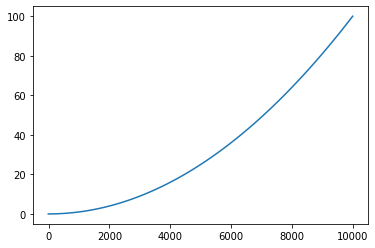

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x/1000)**2

x = torch.linspace(-10, 100*100)
plt.plot(x, area_cost(x))

# Detector panels

In [5]:
c = torch.tensor([0.5,0.5], requires_grad=True)
s = torch.tensor([0.5,1], requires_grad=True)

In [23]:
gauss = torch.distributions.Normal(c, s)

In [24]:
torch.prod(torch.exp(gauss.log_prob(Tensor([[0.5,0.5], [1,1]])))/torch.exp(gauss.log_prob(Tensor([0.5,0.5]))),dim=-1)

tensor([1.0000, 0.5353], grad_fn=<ProdBackward1>)

In [122]:
class DetectorPanel(nn.Module):
    def __init__(
        self,
        res: float,
        eff: float,
        init_xyz:Tuple[float,float,float],
        init_xy_span: Tuple[float,float],
        area_cost_func: Callable[[Tensor], Tensor],
        device: torch.device = DEVICE
    ):
        if res <= 0:
            raise ValueError(f'Resolution must be positive')
        if eff <= 0:
            raise ValueError(f'Efficiency must be positive')
            
        super().__init__()
        self.area_cost_func, self.device = area_cost_func, device
        self.register_buffer('resolution', torch.tensor(float(res), requires_grad=True, device=self.device))
        self.register_buffer('efficiency', torch.tensor(float(eff), requires_grad=True, device=self.device))
        self.xyz = nn.Parameter(torch.tensor(init_xyz, device=self.device))
        self.xy_span = nn.Parameter(torch.tensor(init_xy_span, device=self.device))
        self.realistic_validation = False
        
    def __repr__(self) -> str:
        return f'''{self.__class__} located at {self.xyz.data}, and xy span {self.xy_span.data}'''
    
    def get_xy_mask(self, xy: Tensor) -> Tensor:
        xy_low = self.xy-(self.xy_span/2)
        xy_high = self.xy+(self.xy_span/2)
        return (xy[:,0] >= xy_low[0]) * (xy[:,0] < xy_high[0]) * (xy[:,1] >= xy_low[1]) * (xy[:,1] < xy_high[1])
    
    def get_resolution(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            res = self.resolution*torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            res = torch.zeros((len(xy),2), device=self.device)  # Zero detection outside detector
            res[mask] = self.resolution
        return res
    
    def get_efficiency(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            gauss = torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
            scale = torch.exp(gauss.log_prob(xy))/torch.exp(gauss.log_prob(self.xy))  # Maybe detach the normalisation?
            eff = self.efficiency*torch.prod(scale, dim=-1)  # Maybe weight product by xy distance?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            eff = torch.zeros(len(xy), device=self.device)  # Zero detection outside detector
            eff[mask] = self.efficiency
        return eff
        
    def get_hits(self, mu: MuonBatch) -> Dict[str, Tensor]:
        mask = mu.get_xy_mask(self.xy-(self.xy_span/2), self.xy+(self.xy_span/2))  # Muons in panel
        
        xy0 = self.xy-(self.xy_span/2)  # Low-left of voxel
        rel_xy = mu.xy - xy0
        res = self.get_resolution(mu.xy, mask)        
        rel_xy = rel_xy + (torch.randn((len(mu), 2), device=self.device) / res)
        
        if not self.training and self.realistic_validation:  # Prevent reco hit from exiting panel
            span = self.xy_span.detach().cpu().numpy()
            rel_xy[mask] = torch.stack([torch.clamp(rel_xy[mask][:,0], 0, span[0]),
                                        torch.clamp(rel_xy[mask][:,1], 0, span[1])], dim=-1)  
        reco_xy = xy0 + rel_xy

        hits = {
            "reco_xy": reco_xy,
            "gen_xy": mu.xy.detach().clone(),
            "z": self.z.expand_as(mu.x)[:, None],
        }
        return hits

    def get_cost(self) -> Tensor:
        return self.area_cost_func(self.xy_span.prod())
    
    def clamp_params(self, xyz_low:Tuple[float,float,float], xyz_high:Tuple[float,float,float]) -> None:
        with torch.no_grad():
            eps = np.random.uniform(0, 1e-5)  # prevent hits at same z due to clamping
            torch.clamp_(self.x, min=xyz_low[0], max=xyz_high[0])
            torch.clamp_(self.y, min=xyz_low[1], max=xyz_high[1])
            torch.clamp_(self.z, min=xyz_low[2]+eps, max=xyz_high[2]-eps)
            torch.clamp_(self.xy_span[0], min=1e-7, max=xyz_high[0])
            torch.clamp_(self.xy_span[1], min=1e-7, max=xyz_high[1])
            
    @property
    def xy(self) -> Tensor:
        return self.xyz[:2]
    
    @property
    def x(self) -> Tensor:
        return self.xyz[0]
    
    @property
    def y(self) -> Tensor:
        return self.xyz[1]
    
    @property
    def z(self) -> Tensor:
        return self.xyz[2]

In [123]:
from tomopt.volume.layer import Layer

class DetectorLayer(Layer):
    def __init__(
        self,
        pos: str,
        lw: Tensor,
        z: float,
        size: float,
        panels: nn.ModuleList,
        device: torch.device = DEVICE,
    ):
        super().__init__(lw=lw, z=z, size=size, device=device)
        if isinstance(panels, list):
            panels = nn.ModuleList(panels)
        self.pos, self.panels = pos, panels
    
    def get_panel_zorder(self) -> List[int]:
        return np.argsort([p.z.detach().cpu().item() for p in self.panels])[::-1]
        
    def check_panels(self) -> None:
        lw = self.lw.detach().cpu().numpy()
        z = self.z.detach().cpu()[0]
        zs = []
        for p in self.panels:
            p.clamp_params(xyz_low=(0,0,z-self.size), xyz_high=(lw[0],lw[1],z))
            zs.append(p.z)        
                
    def forward(self, mu: MuonBatch) -> None:
        self.check_panels()
        for i in self.get_panel_zorder():
            self.scatter_and_propagate(mu, mu.z-self.panels[i].z)  # Move to panel
            mu.append_hits(self.panels[i].get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, mu.z-(self.z-self.size))  # Move to bottom of layer

    def get_cost(self) -> Tensor:
        for i, p in enumerate(self.panels):
            cost = p.get_cost() if i == 0 else cost + p.get_cost()
        return cost

In [124]:
panels = nn.ModuleList([DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.5,0.5], area_cost_func=area_cost),
                        DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,1], init_xy_span=[0.5,0.5], area_cost_func=area_cost)])

In [125]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [126]:
muons.xy.grad

In [127]:
panels[0].get_hits(muons)

{'reco_xy': tensor([[0.6117, 0.5969],
         [0.5462, 0.0755],
         [0.2414, 0.6774],
         [0.2318, 0.0786],
         [0.4404, 0.6999],
         [0.0274, 0.2759],
         [0.2883, 0.8956],
         [0.9887, 0.4232],
         [0.6340, 0.3585],
         [0.4959, 0.7116],
         [0.5636, 0.3816],
         [0.9501, 0.3718],
         [0.0165, 0.8491],
         [0.2565, 0.4947],
         [0.2698, 0.0775],
         [0.6958, 0.9195],
         [0.2565, 0.5034],
         [0.0475, 0.2766],
         [0.0487, 0.2467],
         [0.9419, 0.1973],
         [0.7226, 0.9435],
         [0.8230, 0.5695],
         [0.5337, 0.2070],
         [0.7585, 0.5582],
         [0.4859, 0.7568],
         [0.5767, 0.1789],
         [0.5158, 0.7679],
         [0.9271, 0.8002],
         [0.2605, 0.9400],
         [0.4817, 0.1181],
         [0.3508, 0.1615],
         [0.6684, 0.4877],
         [0.5499, 0.5285],
         [0.7328, 0.5551],
         [0.0347, 0.9324],
         [0.1141, 0.5343],
         [0.1932,

In [128]:
muons.xy.grad

In [129]:
dl = DetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=0.1, panels=panels)

In [130]:
dl.get_cost()

tensor(1.2500e-07, grad_fn=<AddBackward0>)

In [131]:
dl.get_panel_zorder()

array([1, 0])

In [132]:
dl.panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
)

In [133]:
dl(muons)

In [134]:
muons.xy.grad

In [135]:
muons.z

tensor([0.9000])

In [136]:
muons.hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.6115, 0.5970],
                                   [0.5461, 0.0755],
                                   [0.2414, 0.6774],
                                   [0.2318, 0.0790],
                                   [0.4405, 0.7000],
                                   [0.0272, 0.2758],
                                   [0.2884, 0.8959],
                                   [0.9888, 0.4230],
                                   [0.6340, 0.3586],
                                   [0.4960, 0.7115],
                                   [0.5637, 0.3814],
                                   [0.9502, 0.3716],
                                   [0.0165, 0.8490],
                                   [0.2562, 0.4946],
                                   [0.2696, 0.0777],
                                   [0.6960, 0.9193],
               

In [137]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(DetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))
    layers.append(DetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [138]:
class Volume(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        if isinstance(layers, list):
            layers = nn.ModuleList(layers)
        self.layers = layers

    def __getitem__(self, idx:int) -> Layer:
        return self.layers[idx]

    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]

    def get_passives(self) -> List[PassiveLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]

    def get_rad_cube(self) -> Tensor:
        vols = list(reversed(self.get_passives()))  # reversed to match lookup_xyz_coords: layer zero = bottom layer
        if len(vols) == 0:
            raise ValueError("self.layers contains no passive layers")
        return torch.stack([v.rad_length for v in vols if v.rad_length is not None], dim=0)

    def lookup_passive_xyz_coords(self, xyz: Tensor) -> Tensor:
        r"""Assume same size for all layers for now and no intermedeate detector layers"""
        if len(xyz.shape) == 1:
            xyz = xyz[None, :]

        if n := (
            ((xyz[:, :2] > self.lw) + (xyz[:, :2] < 0)).sum(1) + (xyz[:, 2] < self.get_passive_z_range()[0]) + ((xyz[:, 2] > self.get_passive_z_range()[1]))
        ).sum():
            raise ValueError(f"{n} Coordinates outside passive volume")
        xyz[:, 2] = xyz[:, 2] - self.get_passive_z_range()[0]
        return torch.floor(xyz / self.size).long()

    def load_rad_length(self, rad_length_func: Callable[..., Tensor]) -> None:
        for p in self.get_passives():
            p.load_rad_length(rad_length_func)

    def forward(self, mu: MuonBatch) -> None:  # Expand to take volume as input, too
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()

    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, "get_cost"):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost + l.get_cost()
        if cost is None:
            cost = torch.zeros((1))
        return cost

    @property
    def lw(self) -> Tensor:
        return self.get_passives()[-1].lw

    @property
    def passive_size(self) -> float:
        return self.get_passives()[-1].size  # Same size for each passive layer

    @property
    def h(self) -> float:
        return self.layers[0].z

    def get_passive_z_range(self) -> Tuple[Tensor, Tensor]:
        ps = self.get_passives()
        return ps[-1].z-self.passive_size, ps[0].z

In [139]:
volume = Volume(get_layers())

In [140]:
volume[0].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
)

In [141]:
for l in volume: print(l.z)

tensor([1.])
tensor([0.8000])
tensor([0.7000])
tensor([0.6000])
tensor([0.5000])
tensor([0.4000])
tensor([0.3000])
tensor([0.2000])


In [142]:
volume.get_passive_z_range()

(tensor([0.2000]), tensor([0.8000]))

In [143]:
volume[-1].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.1500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.1000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.0500]), and xy span tensor([0.5000, 0.5000])
)

In [144]:
volume[0].panels[0].training

True

In [145]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0

In [146]:
volume[0].training

False

In [147]:
volume[0].panels.training

False

# Scatter inference

In [148]:
# volume.train()
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 1.0000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at tensor([0.5000, 0.5000, 0.2000]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at tensor([0

In [149]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [150]:
muons.xy.grad

In [151]:
volume(muons)

In [152]:
muons.xy.grad

In [153]:
hits = muons.get_hits(volume.lw)
above_hits = [torch.cat([hits["above"]["reco_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["reco_xy"].shape[1])]
above_gen_hits = [torch.cat([hits["above"]["gen_xy"][:, i], hits["above"]["z"][:, i]], dim=-1) for i in range(hits["above"]["gen_xy"].shape[1])]
above_hits

[tensor([[0.6797, 0.1707, 1.0000],
         [0.6702, 0.7653, 1.0000],
         [0.7722, 0.8217, 1.0000],
         [0.6758, 0.9589, 1.0000],
         [0.3264, 0.2962, 1.0000],
         [0.1711, 0.1883, 1.0000],
         [0.4114, 0.1408, 1.0000],
         [0.3290, 0.1493, 1.0000],
         [0.1555, 0.9533, 1.0000],
         [0.6869, 0.1890, 1.0000],
         [0.6454, 0.4056, 1.0000],
         [0.2364, 0.7615, 1.0000],
         [0.8213, 0.1241, 1.0000],
         [0.5709, 0.8878, 1.0000],
         [0.1232, 0.4674, 1.0000],
         [0.8712, 0.5509, 1.0000],
         [0.7363, 0.9310, 1.0000],
         [0.6215, 0.2778, 1.0000],
         [0.9745, 0.6205, 1.0000],
         [0.0748, 0.5242, 1.0000],
         [0.1593, 0.6879, 1.0000],
         [0.2331, 0.9196, 1.0000],
         [0.6843, 0.4920, 1.0000],
         [0.7480, 0.5084, 1.0000],
         [0.1607, 0.8154, 1.0000],
         [0.5313, 0.3446, 1.0000],
         [0.1675, 0.2673, 1.0000],
         [0.1835, 0.4679, 1.0000],
         [0.4455, 0.

In [154]:
from tomopt.utils import jacobian
jacobian(above_hits[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[ 2.3595e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.8984e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 8.7546e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.2608e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0212e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  7.4252e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0358e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.1430e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 3.9470e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.5007e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-1.3122e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  2.8138e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[-5.7994e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -8.3102e-04,  0

In [155]:
[h[1] for h in above_hits]

[tensor([0.6702, 0.7653, 1.0000], grad_fn=<SelectBackward>),
 tensor([0.6688, 0.7649, 0.9500], grad_fn=<SelectBackward>),
 tensor([0.6647, 0.7669, 0.9000], grad_fn=<SelectBackward>),
 tensor([0.6601, 0.7654, 0.8500], grad_fn=<SelectBackward>)]

In [156]:
[h[0] for h in above_hits]

[tensor([0.6797, 0.1707, 1.0000], grad_fn=<SelectBackward>),
 tensor([0.6697, 0.1760, 0.9500], grad_fn=<SelectBackward>),
 tensor([0.6606, 0.1800, 0.9000], grad_fn=<SelectBackward>),
 tensor([0.6507, 0.1825, 0.8500], grad_fn=<SelectBackward>)]

In [157]:
def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
    res = []
    for l,h in zip(dets,hits):
        r = 1 / l.get_resolution(h[:,:2])
        res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
    return res

In [158]:
uncs = get_hit_uncs(volume.get_detectors()[0].panels, above_gen_hits)

In [159]:
uncs[0][:10]

tensor([[0.0011, 0.0012, 0.0000],
        [0.0011, 0.0011, 0.0000],
        [0.0012, 0.0012, 0.0000],
        [0.0011, 0.0015, 0.0000],
        [0.0011, 0.0011, 0.0000],
        [0.0012, 0.0012, 0.0000],
        [0.0010, 0.0013, 0.0000],
        [0.0011, 0.0013, 0.0000],
        [0.0013, 0.0015, 0.0000],
        [0.0011, 0.0012, 0.0000]], grad_fn=<SliceBackward>)

In [160]:
[u[1] for u in uncs]

[tensor([0.0011, 0.0011, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0011, 0.0012, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0011, 0.0012, 0.0000], grad_fn=<SelectBackward>),
 tensor([0.0011, 0.0012, 0.0000], grad_fn=<SelectBackward>)]

In [161]:
jacobian(uncs[0], volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-7.6822e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.6259e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-7.2752e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.2147e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.2682e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -1.5867e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-7.5480e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -2.8040e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 7.4021e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  8.9528e-04,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.6266e-03,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.5294e-03,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.5314e-04,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.8555e-03,  0

In [162]:
def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
    r"""
    hits = [muons,(x,y,z)]
    uncs = [(unc,unc,0)]

    Assume no uncertainty for z
    
    In eval mode:
        Muons with <2 hits within panels have NaN trajectory.
        Muons with >=2 hits in panels have valid trajectories
    """

    hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
    hits = torch.where(torch.isinf(hits), torch.tensor([0.5], device=uncs.device), hits)
    
    stars, angles = [],[]
    for i in range(2):  # seperate x and y resolutions
        inv_unc2 = uncs[:, :, i:i+1] ** -2
        sum_inv_unc2 = inv_unc2.sum(dim=1)
        mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
        mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
        mean_x = mean_xz[:, :1]
        mean_z = mean_xz[:, 1:]
        mean_x_z = mean_xz_z[:, :1]
        mean_z2 = mean_xz_z[:, 1:]
        
        stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
        angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

    xy_star = torch.cat(stars, dim=-1)
    angle = torch.cat(angles, dim=-1)

    def _calc_xyz(z: Tensor) -> Tensor:
        return torch.cat([xy_star + (angle * z), z], dim=-1)

    return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])

In [163]:
traj = get_muon_trajectory(above_hits, uncs); traj[:10]

tensor([[-0.0096,  0.0039, -0.0500],
        [-0.0035,  0.0002, -0.0500],
        [-0.0047, -0.0032, -0.0500],
        [ 0.0001, -0.0001, -0.0500],
        [ 0.0014,  0.0118, -0.0500],
        [-0.0071, -0.0032, -0.0500],
        [-0.0059, -0.0056, -0.0500],
        [ 0.0035, -0.0024, -0.0500],
        [ 0.0027, -0.0057, -0.0500],
        [-0.0027,  0.0064, -0.0500]], grad_fn=<SliceBackward>)

In [164]:
jacobian(traj, volume.get_detectors()[0].panels[0].xyz, create_graph=True)

tensor([[[-1.0987e-04,  0.0000e+00, -1.3537e-01],
         [ 0.0000e+00,  9.2364e-06,  5.7753e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 1.1259e-04,  0.0000e+00, -4.4852e-02],
         [ 0.0000e+00,  3.7290e-04,  2.9209e-03],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-1.0917e-04,  0.0000e+00, -6.5227e-02],
         [ 0.0000e+00,  3.9445e-04, -4.1073e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-1.7437e-04,  0.0000e+00,  2.8613e-03],
         [ 0.0000e+00,  8.3369e-04,  2.4126e-03],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-8.4170e-06,  0.0000e+00,  1.8513e-02],
         [ 0.0000e+00, -1.2776e-05,  1.6279e-01],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[ 4.2730e-05,  0.0000e+00, -9.6926e-02],
         [ 0.0000e+00, -5.6295e-04, -4.5839e-02],
         [ 0.0000e+00,  0.0000e+00, -1.0000e+00]],

        [[-6.2317e-06,  0.0000e+00, -7.9001e-02],
         [ 0.0000e+00,  6.3428e-04, -7

In [165]:
from tomopt.utils import jacobian

class PanelScatterBatch(ScatterBatch):
    @staticmethod
    def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
        r"""
        hits = [muons,(x,y,z)]
        uncs = [(unc,unc,0)]

        Assume no uncertainty for z

        In eval mode:
            Muons with <2 hits within panels have NaN trajectory.
            Muons with >=2 hits in panels have valid trajectories
        """

        hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
        hits = torch.where(torch.isinf(hits), torch.tensor([0.5], device=uncs.device), hits)

        stars, angles = [],[]
        for i in range(2):  # seperate x and y resolutions
            inv_unc2 = uncs[:, :, i:i+1] ** -2
            sum_inv_unc2 = inv_unc2.sum(dim=1)
            mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
            mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
            mean_x = mean_xz[:, :1]
            mean_z = mean_xz[:, 1:]
            mean_x_z = mean_xz_z[:, :1]
            mean_z2 = mean_xz_z[:, 1:]

            stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
            angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

        xy_star = torch.cat(stars, dim=-1)
        angle = torch.cat(angles, dim=-1)

        def _calc_xyz(z: Tensor) -> Tensor:
            return torch.cat([xy_star + (angle * z), z], dim=-1)
        
        return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])
    
    @staticmethod
    def get_hit_uncs(zordered_panels: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
        res = []
        for l,h in zip(zordered_panels,hits):
            r = 1 / l.get_resolution(h[:,:2])
            res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
        return res
    
    def compute_tracks(self) -> None:
        # reco x, reco y, gen z, must be a list to allow computation of uncertainty
        self.above_hits = [torch.cat([self.hits["above"]["reco_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["reco_xy"].shape[1])]
        self.below_hits = [torch.cat([self.hits["below"]["reco_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["reco_xy"].shape[1])]
        self.above_gen_hits = [torch.cat([self.hits["above"]["gen_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["gen_xy"].shape[1])]
        self.below_gen_hits = [torch.cat([self.hits["below"]["gen_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["gen_xy"].shape[1])]
        self.n_hits_above = len(self.above_hits)
        
        self.above_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[0].panels[i] for i in self.volume.get_detectors()[0].get_panel_zorder()], self.above_gen_hits)
        self.below_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[1].panels[i] for i in self.volume.get_detectors()[1].get_panel_zorder()], self.below_gen_hits)
    
        self.track_in = self.get_muon_trajectory(self.above_hits, self.above_hit_uncs)
        self.track_out = self.get_muon_trajectory(self.below_hits, self.below_hit_uncs)
        
    def _compute_unc(self, var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        unc2_sum = None
        for i, (xi, unci) in enumerate(zip(hits, hit_uncs)):
            for j, (xj, uncj) in enumerate(zip(hits, hit_uncs)):
                if j < i:
                    continue
                dv_dx_2 = torch.nan_to_num(jacobian(var, xi)).sum(2) * torch.nan_to_num(jacobian(var, xj)).sum(2) if i != j else torch.nan_to_num(jacobian(var, xi)).sum(2) ** 2  # Muons, var_xyz, hit_xyz
                unc_2 = (dv_dx_2 * unci[:, None] * uncj[:, None]).sum(2)  # Muons, (x,y,z)
                if unc2_sum is None:
                    unc2_sum = unc_2
                else:
                    unc2_sum = unc2_sum + unc_2
        return torch.sqrt(unc2_sum)

In [166]:
sb = PanelScatterBatch(muons, volume)

In [167]:
sb.location[:10], sb.location_unc[:10]

(tensor([[ 0.5661,  0.2205,  0.4198],
         [ 0.6281,  0.7727,  0.3826],
         [ 0.6976,  0.7746,  0.2264],
         [ 0.6730,  0.9553,  0.5077],
         [ 0.3512,  0.5136,  0.0786],
         [ 0.1944,  0.2033,  1.1915],
         [ 0.3538,  0.0821,  0.5209],
         [ 0.3629,  0.1258,  0.5179],
         [ 0.2156,  0.8269, -0.1034],
         [ 0.6643,  0.2343,  0.6332]], grad_fn=<SliceBackward>),
 tensor([[0.2389, 0.1038, 1.2690],
         [0.0097, 0.0027, 0.0897],
         [0.0231, 0.0137, 0.2795],
         [0.0027, 0.0033, 0.1299],
         [0.0060, 0.0656, 0.2547],
         [0.2263, 0.0961, 1.6013],
         [0.0615, 0.0553, 0.4832],
         [0.0104, 0.0101, 0.1560],
         [0.0716, 0.1485, 1.3705],
         [0.0123, 0.0268, 0.2261]], grad_fn=<SliceBackward>))

In [168]:
m = sb.get_scatter_mask()

In [169]:
sb.location[m][:10], sb.location_unc[m][:10]

(tensor([[0.5661, 0.2205, 0.4198],
         [0.6281, 0.7727, 0.3826],
         [0.6976, 0.7746, 0.2264],
         [0.6730, 0.9553, 0.5077],
         [0.3538, 0.0821, 0.5209],
         [0.3629, 0.1258, 0.5179],
         [0.6643, 0.2343, 0.6332],
         [0.2319, 0.7024, 0.4168],
         [0.8599, 0.1168, 0.2462],
         [0.6420, 0.8589, 0.4617]], grad_fn=<SliceBackward>),
 tensor([[0.2389, 0.1038, 1.2690],
         [0.0097, 0.0027, 0.0897],
         [0.0231, 0.0137, 0.2795],
         [0.0027, 0.0033, 0.1299],
         [0.0615, 0.0553, 0.4832],
         [0.0104, 0.0101, 0.1560],
         [0.0123, 0.0268, 0.2261],
         [0.0025, 0.0076, 0.1049],
         [0.0190, 0.0031, 0.2765],
         [0.0448, 0.0153, 0.3282]], grad_fn=<SliceBackward>))

## Grad check

In [170]:
jacobian(sb.location[m], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(2)[:10]

tensor([[ 1.1132e+01, -4.7317e+00,  5.7987e+01],
        [ 5.3339e-01, -3.7254e-02,  4.4211e+00],
        [-1.7007e+00, -1.0870e+00, -2.1747e+01],
        [-2.5775e-03,  3.9842e-02, -7.1268e-01],
        [ 4.9255e+00,  4.2422e+00,  3.7792e+01],
        [-1.4025e-01,  1.0743e-01,  1.2112e+00],
        [-4.1816e-01,  1.0100e+00, -9.2995e+00],
        [-5.9128e-02, -4.5158e-01, -7.4009e+00],
        [-3.7583e-01,  5.4567e-02,  5.3133e+00],
        [-1.9622e+00,  6.8385e-01,  1.3492e+01]], grad_fn=<SliceBackward>)

In [171]:
jacobian(sb.location_unc[m], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(2)[:10]

tensor([[ 7.8918e-02,  3.3932e-02,  4.2062e-01],
        [-1.7844e-03, -2.4447e-04, -1.7521e-02],
        [-9.2729e-03, -5.5756e-03, -1.0976e-01],
        [-1.2007e-04, -3.8543e-04, -1.6340e-02],
        [ 1.1499e-02,  9.8736e-03,  9.0541e-02],
        [ 1.7312e-03,  2.0802e-03,  2.8092e-02],
        [ 1.0274e-03,  2.7210e-03,  2.3980e-02],
        [-1.2719e-04, -1.5033e-03, -2.3794e-02],
        [-6.7841e-03,  5.2610e-04, -1.0376e-01],
        [-6.5290e-03, -1.7771e-03, -4.8879e-02]], grad_fn=<SliceBackward>)

In [172]:
jacobian(sb.location_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-5.1894e-02, -2.2301e-02, -2.7646e-01],
        [-7.1620e-04, -1.2555e-04, -7.2761e-03],
        [-5.8220e-03, -3.4353e-03, -6.8313e-02],
        [-6.2983e-05, -3.1525e-04, -1.1116e-02],
        [-7.7513e-03, -6.6893e-03, -6.1204e-02],
        [-1.2163e-03, -1.4513e-03, -1.9575e-02],
        [-8.0687e-04, -2.1261e-03, -1.8622e-02],
        [-1.1526e-04, -8.1937e-04, -1.2803e-02],
        [-4.3838e-03, -4.2825e-04, -6.7080e-02],
        [-4.3439e-03, -1.1393e-03, -3.2804e-02]], grad_fn=<SliceBackward>)

In [173]:
jacobian(sb.dtheta_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-5.5718e-04, -2.2125e-03],
        [-5.0990e-04, -1.2813e-03],
        [-1.4296e-03, -2.1041e-03],
        [-5.4001e-04, -5.2044e-03],
        [-1.1992e-04, -2.4847e-03],
        [-5.0185e-04, -2.4631e-03],
        [-6.0552e-04, -1.9327e-03],
        [-1.2731e-03, -1.2764e-03],
        [-2.0104e-03, -2.9765e-03],
        [-7.7698e-05, -3.3458e-03]], grad_fn=<SliceBackward>)

In [174]:
jacobian(sb.theta_in_unc[m], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-0.0008, -0.0031],
        [-0.0007, -0.0018],
        [-0.0020, -0.0029],
        [-0.0008, -0.0073],
        [-0.0002, -0.0037],
        [-0.0007, -0.0035],
        [-0.0008, -0.0027],
        [-0.0018, -0.0018],
        [-0.0029, -0.0042],
        [-0.0001, -0.0046]], grad_fn=<SliceBackward>)

In [175]:
jacobian(sb.theta_out_unc[m], volume.get_detectors()[1].panels[0].xy_span, create_graph=True).sum(2)[:10]

tensor([[-1.3616e-05, -1.7386e-03],
        [-2.6414e-04, -2.0592e-03],
        [-9.3741e-04, -2.0147e-03],
        [-6.5174e-04, -7.4909e-03],
        [-8.6964e-04, -6.9208e-03],
        [-3.2230e-04, -4.8697e-03],
        [-4.8537e-04, -1.2338e-03],
        [-1.9267e-03, -8.9342e-04],
        [-3.9181e-03, -4.5116e-03],
        [-7.4843e-04, -3.5304e-03]], grad_fn=<SliceBackward>)

# X0 inference

In [176]:
class PanelX0Inferer(X0Inferer):
    def compute_efficiency(self) -> Tensor:
        eff = None
        for pos, hits in enumerate([self.scatters.above_gen_hits, self.scatters.below_gen_hits]):
            leff = None
            layer = self.volume.get_detectors()[pos]
            panel_idxs = layer.get_panel_zorder()
            effs = torch.stack([layer.panels[i].get_efficiency(hits[i][self.mask,:2]) for i in panel_idxs], dim=0)
            for r in range(2,len(effs)+1):  # Muon goes through any combination of at least 2 panels
                c = torch.combinations(torch.arange(0,len(effs)), r=r)
                e = effs[c].prod(1).sum(0)  
                if leff is None:
                    leff = e
                else:
                    leff = leff + e
            if eff is None:
                eff = leff
            else:
                eff = eff * leff  # Muons detected above & below passive volume
        return eff

In [177]:
x0inf = PanelX0Inferer(sb)

In [178]:
eff = x0inf.compute_efficiency(); eff

tensor([1.7560, 1.8236, 1.1908, 0.4791, 0.6976, 0.9620, 1.7942, 1.4179, 0.3910,
        1.0529, 0.8915, 0.3232, 0.7253, 0.9119, 0.3272, 3.1128, 1.4100, 3.0657,
        0.4954, 1.5450, 4.1755, 0.8555, 1.6715, 2.8556, 1.1994, 3.5691, 0.6792,
        1.8053, 1.7021, 1.3952, 2.5019, 0.3356, 0.7032, 1.9198, 1.9535, 1.4161,
        1.9715, 1.0862, 0.7594, 0.2101, 1.9778, 0.3147, 1.7524, 2.2493, 2.6042,
        1.1495, 1.7030, 1.6979, 0.6383, 0.3843, 0.9962, 2.5954, 0.7948, 2.3090,
        2.8930, 1.8555, 2.3134], grad_fn=<MulBackward0>)

## grad check

In [179]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([-0.5754,  1.7882,  1.5624,  0.6692, -0.7006, -1.1201, -0.4962, -0.0062,
        -0.0451,  1.0729], grad_fn=<SumBackward1>)

In [180]:
jacobian(eff[:10], volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([1.0889, 0.8142, 0.9366, 0.5098, 0.4282, 0.6538, 1.0480, 0.8676, 0.4208,
        0.7273], grad_fn=<SumBackward1>)

## pred

In [181]:
pred_dtheta, pred_dtheta_unc = x0inf.x0_from_dtheta()

In [182]:
pred_dtheta.shape

torch.Size([57])

In [183]:
pred_dtheta[:10], pred_dtheta_unc[:10]

(tensor([0.0188, 0.0006, 0.0035, 0.0008, 0.0047, 0.0016, 0.0030, 0.0009, 0.0030,
         0.0073], grad_fn=<SliceBackward>),
 tensor([0.0386, 0.0002, 0.0034, 0.0005, 0.0049, 0.0012, 0.0027, 0.0004, 0.0030,
         0.0113], grad_fn=<SliceBackward>))

In [184]:
torch.autograd.grad(pred_dtheta[0], volume.get_detectors()[0].panels[0].xyz, retain_graph=True, create_graph=True)#.sum(1)

(tensor([-8.0500e-03,  3.5443e-04,  3.4095e+00], grad_fn=<AddBackward0>),)

In [185]:
jacobian(pred_dtheta, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([-3.1305e-03, -6.1154e-06,  7.5521e-04,  4.9759e-04, -8.0290e-04,
         1.0548e-03,  2.4941e-03,  2.6809e-04,  2.0580e-03, -1.0175e-03,
         2.8034e-04, -6.1618e-04,  3.5078e-01, -3.3999e-03,  2.6232e-03,
         1.8019e-04, -4.0985e-04, -6.3765e-05, -4.0149e-03,  2.8586e-04,
         3.9554e-05,  2.3698e-04,  3.1043e-04,  8.7524e-04,  3.2927e-03,
        -5.5828e-05,  4.2592e-04,  3.3482e-04,  5.6653e-04, -2.0548e-05,
         1.0206e-05,  3.9911e-04,  7.3976e-03, -8.1865e-04,  3.0281e-05,
         3.2338e-03,  4.0411e-04,  3.0494e-04,  1.4245e-03, -3.6042e-03,
         4.6674e-04, -3.4401e-05,  4.7098e-05, -1.3669e-03,  3.3967e-04,
         6.3226e-02,  4.9033e-04, -4.6119e-05,  3.6995e-04,  1.3482e-03,
         5.8204e-04,  4.5967e-04,  6.0327e-03,  8.3747e-04,  4.8248e-04,
        -5.4339e-05,  9.8931e-03], grad_fn=<SumBackward1>)

In [186]:
jacobian(pred_dtheta_unc, volume.get_detectors()[0].panels[0].xyz, create_graph=True).sum(1)

tensor([-2.1150e-03, -3.5356e-05, -9.5985e-04, -1.7233e-04,  4.1737e-04,
         3.4910e-04,  5.7870e-04, -1.0107e-04, -4.8273e-04, -3.5037e-03,
         3.2177e-04, -1.4555e-04, -7.5852e-02,  1.0035e-03, -1.1875e-04,
        -1.6299e-04, -1.1846e-04, -2.3588e-05,  6.9049e-03,  4.8585e-05,
        -1.9037e-04, -2.1603e-04,  4.5410e-05,  2.2577e-03,  1.3479e-03,
         1.3446e-03,  4.7449e-05, -2.7659e-04,  8.7779e-04, -2.3593e-04,
        -4.0125e-05,  1.1480e-03, -4.2198e-03,  1.4323e-03,  1.2823e-05,
         3.5517e-03,  8.9943e-05, -1.0555e-04,  3.4033e-04,  5.3388e-03,
         1.8711e-04,  1.5719e-04, -1.1976e-04,  1.2225e-03,  1.2332e-04,
         4.3667e-02,  1.9773e-03, -6.2079e-05, -1.4774e-03, -1.3905e-04,
        -2.1444e-04,  3.3511e-04, -1.2613e-03, -3.8699e-04,  5.7294e-04,
         6.9451e-04, -3.9957e-03], grad_fn=<SumBackward1>)

In [187]:
jacobian(pred_dtheta_unc, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum(1)

tensor([-3.7970e-03, -1.2324e-05, -5.6841e-04, -1.5239e-04, -1.1002e-04,
        -2.4067e-04, -4.5127e-04, -5.3959e-05, -5.7657e-04, -2.6316e-03,
        -2.4351e-04, -9.7464e-05, -4.1803e-02, -1.0294e-03, -3.8130e-04,
        -6.1956e-05, -5.7269e-05, -1.3371e-05, -3.6300e-03, -2.9698e-05,
        -1.3737e-05, -1.8077e-04, -2.6204e-05, -3.9006e-04, -6.8410e-04,
        -2.5736e-04, -3.6648e-05, -2.0124e-04, -4.4899e-04, -9.5867e-05,
        -9.8416e-06, -7.3131e-04, -2.6646e-03, -8.9821e-04, -1.9116e-06,
        -1.5038e-03, -6.0912e-05, -7.7670e-05, -2.4582e-04, -5.8017e-03,
        -1.2573e-04, -1.2771e-04, -4.6898e-05, -7.7797e-04, -6.4471e-05,
        -2.7214e-02, -1.2337e-03, -2.3095e-05, -1.3047e-03, -3.5694e-04,
        -1.7084e-04, -1.7668e-04, -1.6673e-03, -1.7316e-04, -1.6612e-04,
        -4.3402e-04, -1.7810e-03], grad_fn=<SumBackward1>)

In [188]:
pred, weight = x0inf.average_preds(x0_dtheta=pred_dtheta, x0_dtheta_unc=pred_dtheta_unc, x0_dxy=None, x0_dxy_unc=None, efficiency=eff)

In [189]:
pred, weight = x0inf.pred_x0(False)
pred.shape, weight.shape

(torch.Size([6, 10, 10]), torch.Size([6, 10, 10]))

In [190]:
jacobian(pred, volume.get_detectors()[0].panels[0].xyz, create_graph=True)#.sum(1)

tensor([[[[ 7.1990e-04, -1.8323e-03, -3.6825e-01],
          [ 1.0875e-03, -1.9351e-03, -2.4092e-01],
          [ 1.1123e-03, -2.1316e-03, -2.5688e-01],
          ...,
          [-6.6529e-04,  2.5108e-04, -3.0628e-02],
          [ 9.4542e-04,  7.9029e-03, -1.3726e-01],
          [-1.2876e-03,  1.7422e-03,  9.9677e-02]],

         [[-1.5805e-04,  1.6428e-04, -8.9240e-04],
          [ 7.2347e-04, -2.2345e-03, -3.8071e-01],
          [ 1.5345e-04, -5.6565e-03, -4.5678e-01],
          ...,
          [-7.7230e-04,  6.3623e-05,  4.2231e-02],
          [-1.0322e-04,  5.4161e-04,  4.9214e-02],
          [-1.8546e-03,  1.5420e-03,  1.0147e-01]],

         [[ 6.7974e-05,  1.1368e-03, -3.3781e-01],
          [-1.7526e-04,  2.4496e-04, -3.5580e-01],
          [-2.6924e-04, -3.8384e-03, -2.3756e-01],
          ...,
          [-7.5830e-04,  5.8702e-05,  4.1587e-02],
          [-2.8416e-04,  1.8139e-03, -1.9487e-04],
          [-1.8179e-03,  1.2903e-03,  1.1083e-01]],

         ...,

         [[-1.50

In [191]:
jacobian(pred, volume.get_detectors()[0].panels[0].xy_span, create_graph=True)#.sum(1)

tensor([[[[-5.3902e-04,  8.6239e-04],
          [-8.2993e-04,  9.1068e-04],
          [-9.9162e-04,  9.8930e-04],
          ...,
          [ 5.4129e-04,  1.1113e-04],
          [-4.4622e-04,  5.7731e-03],
          [ 6.4821e-04,  1.4316e-03]],

         [[ 1.0181e-04, -1.3828e-04],
          [-5.5444e-04,  1.0685e-03],
          [-1.4294e-04,  2.8569e-03],
          ...,
          [ 3.8801e-04,  3.5902e-05],
          [ 6.5658e-05,  4.2343e-04],
          [ 9.7146e-04,  1.2730e-03]],

         [[-9.0553e-06, -8.1542e-04],
          [ 1.2006e-04, -3.5532e-04],
          [ 1.1240e-04,  1.8743e-03],
          ...,
          [ 3.8005e-04,  3.3535e-05],
          [ 2.1436e-04,  1.4403e-03],
          [ 9.5026e-04,  1.0645e-03]],

         ...,

         [[-1.3621e-02,  5.0674e-03],
          [ 1.2787e-03,  1.8205e-02],
          [-5.5359e-04,  6.8910e-03],
          ...,
          [ 7.9728e-05,  1.3000e-04],
          [ 9.8020e-05,  2.0558e-04],
          [-3.9757e-05, -5.0840e-04]],

     

In [192]:
jacobian(weight, volume.get_detectors()[0].panels[0].xyz, create_graph=True)#.sum(1)

tensor([[[[-1.8970e+01, -2.8682e+01, -3.9344e+03],
          [-1.4958e+02, -1.5261e+02, -1.2114e+04],
          [-1.5952e+02, -9.9448e+01, -2.3476e+03],
          ...,
          [ 1.0920e+03,  1.4636e+02,  2.7996e+04],
          [ 3.7475e-01,  2.3227e+00,  7.7125e+02],
          [-4.4482e+01, -1.9910e+00,  1.0529e+03]],

         [[-2.7439e+04, -3.0347e+05, -5.9936e+04],
          [-8.1432e+02, -6.2117e+02,  5.0669e+03],
          [-2.6738e+03, -3.0965e+03,  8.3207e+04],
          ...,
          [-9.5856e+05,  3.7506e+05,  1.3364e+07],
          [-4.0990e+03,  1.5067e+03,  1.0726e+05],
          [-1.0765e+04,  6.9295e+03,  1.7898e+05]],

         [[-5.1147e+01, -4.1686e+02, -2.3161e+04],
          [-3.4789e+01, -9.8192e+01,  2.6728e+03],
          [-1.6434e+02, -5.9440e+02,  5.5778e+04],
          ...,
          [-5.2035e+05,  5.2351e+05, -1.1756e+07],
          [-3.8148e+03,  2.5742e+03,  7.9332e+04],
          [-4.8706e+03,  1.1137e+04, -1.1780e+05]],

         ...,

         [[ 9.15

In [193]:
jacobian(weight, volume.get_detectors()[0].panels[0].xy_span, create_graph=True)#.sum(1)

tensor([[[[ 1.4306e+01,  1.3541e+01],
          [ 1.1213e+02,  7.1991e+01],
          [ 1.1793e+02,  4.6487e+01],
          ...,
          [-8.5285e+02,  6.6769e+01],
          [-3.2855e-01,  1.5832e+00],
          [ 2.2755e+01, -1.9751e+00]],

         [[ 1.7651e+04,  2.5238e+05],
          [ 6.1452e+02,  2.9545e+02],
          [ 1.7025e+03,  1.5543e+03],
          ...,
          [ 4.8034e+05,  2.1402e+05],
          [ 2.0589e+03,  8.3363e+02],
          [ 5.6086e+03,  5.7118e+03]],

         [[ 9.0031e+00,  2.9903e+02],
          [ 1.7123e+00,  7.0413e+01],
          [ 1.1441e+02,  3.1849e+02],
          ...,
          [ 2.6094e+05,  3.0430e+05],
          [ 1.9645e+03,  1.4397e+03],
          [ 2.4065e+03,  9.3694e+03]],

         ...,

         [[ 8.2892e+00,  4.1594e+00],
          [-9.5620e-01, -2.9775e+01],
          [ 1.8949e+01, -1.5131e+02],
          ...,
          [ 2.5928e+05,  4.4001e+05],
          [ 7.1951e+05,  4.5542e+06],
          [ 2.6234e+03,  1.2867e+04]],

     

# Loss

In [194]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [195]:
volume = Volume(get_layers())

In [196]:
volume(muons)

In [197]:
sb = PanelScatterBatch(muons, volume)

In [198]:
x0inf = PanelX0Inferer(sb)

In [199]:
pred, weight = x0inf.pred_x0(False)

In [200]:
loss_func = DetectorLoss(0)

In [201]:
loss = loss_func(pred, weight, volume)

In [202]:
loss.backward()

In [203]:
for d in volume.get_detectors():
    for p in d.panels:
        print(p.xyz.grad, p.xy_span.grad)

tensor([  -360.1180,  -3106.2915, 254663.3438]) tensor([  35.0610, 2005.7985])
tensor([-5.8369e+01, -7.5566e+02,  9.2863e+04]) tensor([ -1.7537, 477.7141])
tensor([   227.6382,   -245.7959, -78496.7891]) tensor([-44.0171, -89.8380])
tensor([    575.7497,   -4057.0532, -295234.1250]) tensor([-101.1535, 2861.2043])
tensor([  -1009.1229,  -16869.5566, -119926.3281]) tensor([   84.4771, 11421.3125])
tensor([  -240.2048,  -1073.9987, -62620.2539]) tensor([-106.2072,  839.5753])
tensor([ -148.3456, -2435.4785, 29767.4746]) tensor([ -18.9898, 1363.6329])
tensor([ -1868.3062,  -8455.9092, 178879.1250]) tensor([ 642.6339, 4671.1992])


# VolumeWrapper

In [204]:
from functools import partial

In [250]:
from abc import ABCMeta, abstractmethod
from __future__ import annotations
from fastcore.all import Path
from typing import Callable, Iterator, Optional, List, Any, Tuple, Union
from fastprogress.fastprogress import ConsoleProgressBar, NBProgressBar, ProgressBar
from fastprogress import master_bar, progress_bar
import numpy as np

import torch
from torch import nn, Tensor

from tomopt.optimisation.callbacks.cyclic_callbacks import CyclicCallback
from tomopt.optimisation.callbacks.eval_metric import EvalMetric
from tomopt.optimisation.wrapper.volume_wrapper import FitParams

class AbsVolumeWrapper(metaclass=ABCMeta):
    def __init__(
        self,
        volume: Volume,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ):
        self.volume, self.loss_func, self.default_pred, self.mu_generator = volume, loss_func, default_pred, mu_generator
        self.partial_scatter_inferer, self.partial_x0_inferer = partial_scatter_inferer, partial_x0_inferer
        self._build_opt(**partial_opts)
        self.parameters = self.volume.parameters
    
    @abstractmethod
    def _build_opt(
        self, **kwargs
    ) -> None:
        r'''
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        '''
        pass

    def get_detectors(self) -> List[DetectorLayer]:
        return self.volume.get_detectors()

    def save(self, name: str) -> None:
        torch.save({"volume": self.volume.state_dict(), **{k:v.state_dict() for k,v in self.opts.items()}}, str(name))

    def load(self, name: str) -> None:
        state = torch.load(name, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.volume.load_state_dict(state["volume"])
        for k,v in state.items():
            if '_opt' in k: self.opts[k].load_state_dict(v)

    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ) -> VolumeWrapper:
        vw = cls(volume=volume, partial_opts=partial_opts, loss_func=loss_func, default_pred=default_pred, mu_generator=mu_generator, partial_scatter_inferer=partial_scatter_inferer, partial_x0_inferer=partial_x0_inferer)
        vw.load(name)
        return vw

    def get_param_count(self, trainable: bool = True) -> int:
        r"""
        Return number of parameters in detector.

        Arguments:
            trainable: if true (default) only count trainable parameters

        Returns:
            Number of (trainable) parameters in detector
        """

        return sum(p.numel() for p in self.parameters() if p.requires_grad or not trainable)

    def _scan_volume(self) -> None:
        # Scan volume with muon batches
        self.fit_params.wpreds, self.fit_params.weights = [], []
        if self.fit_params.state != "test":
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), display=False, leave=False)
        else:
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), parent=self.fit_params.passive_bar)
        for _ in muon_bar:
            self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h)
            for c in self.fit_params.cbs:
                c.on_mu_batch_begin()
            self.volume(self.fit_params.mu)
            self.fit_params.sb = self.partial_scatter_inferer(self.fit_params.mu, self.volume)
            for c in self.fit_params.cbs:
                c.on_scatter_end()
            inferer = self.partial_x0_inferer(self.fit_params.sb, self.default_pred)
            pred, wgt = inferer.pred_x0(inc_default=False)
            pred = torch.nan_to_num(pred)
            self.fit_params.wpreds.append(pred * wgt)
            self.fit_params.weights.append(wgt)
            for c in self.fit_params.cbs:
                c.on_mu_batch_end()

        # Predict volume based on all muon batches
        for c in self.fit_params.cbs:
            c.on_x0_pred_begin()
        wgt = torch.stack(self.fit_params.weights, dim=0).sum(0)
        pred = torch.stack(self.fit_params.wpreds, dim=0).sum(0) / wgt
        if self.fit_params.use_default_pred:
            pred, wgt = inferer.add_default_pred(pred, wgt)
        self.fit_params.weight = wgt
        self.fit_params.pred = pred
        
        print(pred.mean())

        for c in self.fit_params.cbs:
            c.on_x0_pred_end()

        # Compute loss for volume
        if self.fit_params.state != "test" and self.loss_func is not None:
            loss = self.loss_func(pred_x0=self.fit_params.pred, pred_weight=self.fit_params.weight, volume=self.volume)
            if self.fit_params.loss_val is None:
                self.fit_params.loss_val = loss
            else:
                self.fit_params.loss_val = self.fit_params.loss_val + loss

    def _scan_volumes(self, passives: PassiveYielder) -> None:
        if self.fit_params.state == "test":
            self.fit_params.passive_bar = master_bar(passives)
        for i, passive in enumerate(self.fit_params.passive_bar if self.fit_params.state == "test" else passives):
            self.fit_params.volume_id = i
            if self.fit_params.state != "test" and i % self.fit_params.passive_bs == 0:  # Volume batch start
                self.fit_params.loss_val = None
                for c in self.fit_params.cbs:
                    c.on_volume_batch_begin()

            self.volume.load_rad_length(passive)
            for c in self.fit_params.cbs:
                c.on_volume_begin()
            self._scan_volume()
            for c in self.fit_params.cbs:
                c.on_volume_end()

            if self.fit_params.state != "test" and (i + 1) % self.fit_params.passive_bs == 0:  # Volume batch end
                if self.fit_params.loss_val is not None:
                    self.fit_params.mean_loss = self.fit_params.loss_val / self.fit_params.passive_bs
                for c in self.fit_params.cbs:
                    c.on_volume_batch_end()

                if self.fit_params.state == "train":
                    # Compute update step
                    for o in self.opts.values():
                        o.zero_grad()
                    for c in self.fit_params.cbs:
                        c.on_backwards_begin()
                    self.fit_params.mean_loss.backward()
                    for c in self.fit_params.cbs:
                        c.on_backwards_end()        
                    for o in self.opts.values():
                        o.step()
                    
                    for d in volume.get_detectors():
                        for p in d.panels:
                            print('xyz', p.xyz.data, p.xyz.grad)
                    for d in volume.get_detectors():
                        for p in d.panels:
                            print('xy_span', p.xy_span.data, p.xy_span.grad)

                if len(passives) - (i + 1) < self.fit_params.passive_bs:
                    break

    def _fit_epoch(self) -> None:
        def run_epoch(passives: PassiveYielder) -> None:
            for c in self.fit_params.cbs:
                c.on_epoch_begin()
            self._scan_volumes(passives)
            for c in self.fit_params.cbs:
                c.on_epoch_end()

        self.fit_params.epoch += 1
        # Training
        self.volume.train()
        self.fit_params.state = "train"
        run_epoch(self.fit_params.trn_passives)

        # Validation
        if self.fit_params.val_passives is not None:
            self.volume.eval()
            self.fit_params.state = "valid"
            run_epoch(self.fit_params.val_passives)

    @staticmethod
    def _sort_cbs(cbs: List[Callback]) -> Tuple[List[CyclicCallback], Optional[MetricLogger], Optional[List[EvalMetric]]]:
        cyclic_cbs, metric_log, metric_cbs = [], None, []
        for c in cbs:
            if isinstance(c, CyclicCallback):
                cyclic_cbs.append(c)  # CBs that might prevent a wrapper from stopping training due to a hyper-param cycle
            if isinstance(c, MetricLogger):
                metric_log = c  # CB that logs losses and eval_metrics
            if isinstance(c, EvalMetric):
                metric_cbs.append(c)  # CB that computes additional performance metrics
        return cyclic_cbs, metric_log, metric_cbs

    def fit(
        self,
        n_epochs: int,
        passive_bs: int,
        n_mu_per_volume: int,
        mu_bs: int,
        trn_passives: PassiveYielder,
        val_passives: Optional[PassiveYielder],
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Callback]:

        if cbs is None:
            cbs = []
        cyclic_cbs, metric_log, metric_cbs = self._sort_cbs(cbs)

        self.fit_params = FitParams(
            cbs=cbs,
            cyclic_cbs=cyclic_cbs,
            metric_log=metric_log,
            metric_cbs=metric_cbs,
            stop=False,
            n_epochs=n_epochs,
            mu_bs=mu_bs,
            n_mu_per_volume=n_mu_per_volume,
            cb_savepath=Path(cb_savepath),
            trn_passives=trn_passives,
            val_passives=val_passives,
            passive_bs=passive_bs,
        )
        self.fit_params.cb_savepath.mkdir(parents=True, exist_ok=True)
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            for c in self.fit_params.cbs:
                c.on_train_begin()
            self.fit_params.epoch_bar = progress_bar(range(self.fit_params.n_epochs))
            for e in self.fit_params.epoch_bar:
                self._fit_epoch()
                if self.fit_params.stop:
                    break
            for c in self.fit_params.cbs:
                c.on_train_end()
        finally:
            self.fit_params = None
            torch.cuda.empty_cache()
        return cbs

    def predict(
        self,
        passives: PassiveYielder,
        n_mu_per_volume: int,
        mu_bs: int,
        use_default_pred: bool = False,
        pred_cb: PredHandler = PredHandler(),
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        if cbs is None:
            cbs = []
        cbs.append(pred_cb)
        passives.shuffle = False

        self.fit_params = FitParams(
            n_mu_per_volume=n_mu_per_volume,
            mu_bs=mu_bs,
            cbs=cbs,
            tst_passives=passives,
            state="test",
            cb_savepath=cb_savepath,
            use_default_pred=use_default_pred,
        )
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            self.volume.eval()
            for c in self.fit_params.cbs:
                c.on_pred_begin()
            self._scan_volumes(self.fit_params.tst_passives)
            for c in self.fit_params.cbs:
                c.on_pred_end()
        finally:
            self.fit_params = None
            cbs.pop()  # Remove pred_cb to avoid mutating cbs
            torch.cuda.empty_cache()
        return pred_cb.get_preds()

    def get_opt_lr(self, opt:str) -> float:
        return self.opts[opt].param_groups[0]["lr"]

    def set_opt_lr(self, lr: float, opt:str) -> None:
        self.opts[opt].param_groups[0]["lr"] = lr

    def get_opt_mom(self, opt:str) -> float:
        if "betas" in self.opts[opt].param_groups[0]:
            return self.opts[opt].param_groups[0]["betas"][0]
        else:
            return self.opts[opt].param_groups[0]["momentum"]

    def set_opt_mom(self, mom: float, opt:str) -> None:
        if "betas" in self.opts[opt].param_groups[0]:
            self.opts[opt].param_groups[0]["betas"] = (mom, self.opts[opt].param_groups[0]["betas"][1])
        else:
            self.opts[opt].param_groups[0]["momentum"] = mom

In [251]:
class VolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        res_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        eff_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

    def _build_opt(
        self, res_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer], eff_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]
    ) -> None:
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

In [252]:
class PanelVolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        xyz_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        xy_span_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'xyz_opt':xyz_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

    def _build_opt(
        self, xyz_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer], xy_span_opt: Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]
    ) -> None:
        self.opts = {'xyz_opt': xyz_opt((p.xyz for l in self.volume.get_detectors() for p in l.panels)),
                     'xy_span_opt': xy_span_opt((p.xy_span for l in self.volume.get_detectors() for p in l.panels))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'xyz_opt':xyz_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

In [260]:
volume = Volume(get_layers())

In [261]:
wrapper = PanelVolumeWrapper(volume=volume, xyz_opt=partial(torch.optim.SGD, lr=2e-5), xy_span_opt=partial(torch.optim.SGD, lr=2e-10),
                        loss_func=DetectorLoss(0))

In [262]:
from tomopt.optimisation import MetricLogger

In [263]:
ml = MetricLogger(show_plots=True)

In [264]:
trn_passives = PassiveYielder([arb_rad_length])

In [265]:
from tomopt.optimisation.callbacks.callback import Callback

In [266]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=100, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=None, cbs=[])

tensor(0.0052, grad_fn=<MeanBackward0>)
xyz tensor([0.5000, 0.5000, 0.9995]) tensor([-0.6516, -0.1345, 24.9300])
xyz tensor([0.5000, 0.5000, 0.9500]) tensor([-0.0020, -0.0805,  0.7545])
xyz tensor([0.5000, 0.5000, 0.9002]) tensor([ -0.0118,  -0.0844, -11.4972])
xyz tensor([0.5000, 0.5000, 0.8502]) tensor([ 0.8432, -0.1411, -7.6863])
xyz tensor([0.5000, 0.5000, 0.2011]) tensor([-8.0928e-01,  7.2403e-03, -5.4782e+01])
xyz tensor([0.5000, 0.5000, 0.1502]) tensor([-2.2053e-01,  2.8706e-03, -1.2352e+01])
xyz tensor([0.5000, 0.5000, 0.0996]) tensor([1.9673e-01, 9.7883e-03, 1.9111e+01])
xyz tensor([0.5000, 0.5000, 0.0492]) tensor([-7.8886e-01,  1.3428e-02,  4.1583e+01])
xy_span tensor([0.5000, 0.5000]) tensor([ 0.3720, -0.0405])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0575, -0.0390])
xy_span tensor([0.5000, 0.5000]) tensor([-0.0112, -0.0400])
xy_span tensor([0.5000, 0.5000]) tensor([-0.5232, -0.0371])
xy_span tensor([0.5000, 0.5000]) tensor([0.7737, 0.0038])
xy_span tensor([0.5000, 0.5000

ValueError: The parameter loc has invalid values

In [249]:
for d in volume.get_detectors():
    for p in d.panels:
        print('xyz', p.xyz.data, p.xyz.grad)
for d in volume.get_detectors():
    for p in d.panels:
        print('xy_span', p.xy_span.data, p.xy_span.grad)

xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xyz tensor([nan, nan, nan]) tensor([nan, nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])
xy_span tensor([nan, nan]) tensor([nan, nan])


In [216]:
muons = MuonBatch(generate_batch(100), 1)

In [217]:
volume(muons)

ValueError: The parameter loc has invalid values

In [ ]:
sb = PanelScatterBatch(muons, volume)